In [1]:
# import libraries
!pip install plotly xgboost imblearn 
!pip install scikit-plot
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report,brier_score_loss,log_loss,average_precision_score,roc_auc_score,confusion_matrix,roc_curve
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.metrics import geometric_mean_score
# For reproducible results
RANDOM_STATE_SEED = 420

In [2]:
d1 = pd.read_csv("02-14-2018.csv")
d2 = pd.read_csv("02-15-2018.csv")
d3 = pd.read_csv("02-16-2018.csv")
d4 = pd.read_csv("02-21-2018.csv")
d7 = pd.read_csv("03-02-2018.csv")

In [3]:
d1['Timestamp']=pd.to_datetime(d1["Timestamp"], format = "%d/%m/%Y %H:%M:%S")
d2["Timestamp"]=pd.to_datetime(d2["Timestamp"], format = "%d/%m/%Y %H:%M:%S")
d3["Timestamp"]=pd.to_datetime(d3["Timestamp"], format = "%d/%m/%Y %H:%M:%S")
d4["Timestamp"]=pd.to_datetime(d4["Timestamp"], format = "%d/%m/%Y %H:%M:%S")
d7["Timestamp"]=pd.to_datetime(d7["Timestamp"], format = "%d/%m/%Y %H:%M:%S")

In [4]:
data=pd.concat([d1,d2,d3,d4,d7],axis=0)
data

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0.0,2018-02-14 08:31:01,112641719.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56320859.5,139.300036,56320958.0,56320761.0,Benign
1,0,0.0,2018-02-14 08:33:50,112641466.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56320733.0,114.551299,56320814.0,56320652.0,Benign
2,0,0.0,2018-02-14 08:36:39,112638623.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56319311.5,301.934596,56319525.0,56319098.0,Benign
3,22,6.0,2018-02-14 08:40:13,6453966.0,15.0,10.0,1239.0,2273.0,744.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,22,6.0,2018-02-14 08:40:23,8804066.0,14.0,11.0,1143.0,2209.0,744.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88637,53,17.0,2018-03-02 09:51:29,1217.0,1.0,1.0,30.0,78.0,30.0,30.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
88638,3389,6.0,2018-03-02 03:40:51,1711199.0,8.0,7.0,1144.0,1581.0,677.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
88639,445,6.0,2018-03-02 10:55:55,543763.0,7.0,4.0,286.0,170.0,103.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
88640,53,17.0,2018-03-02 08:59:29,411.0,1.0,1.0,42.0,58.0,42.0,42.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign


In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 491017 entries, 0 to 88641
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Dst Port           491017 non-null  int64         
 1   Protocol           491016 non-null  float64       
 2   Timestamp          491016 non-null  datetime64[ns]
 3   Flow Duration      491016 non-null  float64       
 4   Tot Fwd Pkts       491016 non-null  float64       
 5   Tot Bwd Pkts       491016 non-null  float64       
 6   TotLen Fwd Pkts    491016 non-null  float64       
 7   TotLen Bwd Pkts    491016 non-null  float64       
 8   Fwd Pkt Len Max    491016 non-null  float64       
 9   Fwd Pkt Len Min    491016 non-null  float64       
 10  Fwd Pkt Len Mean   491016 non-null  float64       
 11  Fwd Pkt Len Std    491016 non-null  float64       
 12  Bwd Pkt Len Max    491016 non-null  float64       
 13  Bwd Pkt Len Min    491016 non-null  float64  

In [6]:
# Data shape
print('train data:',data.shape)

train data: (491017, 80)


In [7]:
data.head(10)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0.0,2018-02-14 08:31:01,112641719.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56320859.5,139.300036,56320958.0,56320761.0,Benign
1,0,0.0,2018-02-14 08:33:50,112641466.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56320733.0,114.551299,56320814.0,56320652.0,Benign
2,0,0.0,2018-02-14 08:36:39,112638623.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56319311.5,301.934596,56319525.0,56319098.0,Benign
3,22,6.0,2018-02-14 08:40:13,6453966.0,15.0,10.0,1239.0,2273.0,744.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,22,6.0,2018-02-14 08:40:23,8804066.0,14.0,11.0,1143.0,2209.0,744.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
5,22,6.0,2018-02-14 08:40:31,6989341.0,16.0,12.0,1239.0,2273.0,744.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
6,0,0.0,2018-02-14 08:39:28,112640480.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56320240.0,203.646753,56320384.0,56320096.0,Benign
7,0,0.0,2018-02-14 08:42:17,112641244.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,56320622.0,62.225397,56320666.0,56320578.0,Benign
8,80,6.0,2018-02-14 08:47:14,476513.0,5.0,3.0,211.0,463.0,211.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
9,80,6.0,2018-02-14 08:47:15,475048.0,5.0,3.0,220.0,472.0,220.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign


In [8]:
data.replace(to_replace=['FTP-BruteForce','DoS attacks-GoldenEye', 'DoS attacks-Slowloris','DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk',"DDOS attack-HOIC","Bot","DDOS attack-LOIC-UDP"], value="Malicious", inplace=True)

In [9]:
# attack Count
print('Target Variable')
print(data.groupby(['Label']).count())

Target Variable
           Dst Port  Protocol  Timestamp  Flow Duration  Tot Fwd Pkts  \
Label                                                                   
Benign        41195     41195      41195          41195         41195   
Malicious    449817    449817     449817         449817        449817   

           Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
Label                                                                        
Benign            41195            41195            41195            41195   
Malicious        449817           449817           449817           449817   

           Fwd Pkt Len Min  ...  Fwd Act Data Pkts  Fwd Seg Size Min  \
Label                       ...                                        
Benign               41195  ...              41195             41195   
Malicious           449817  ...             449817            449817   

           Active Mean  Active Std  Active Max  Active Min  Idle Mean  \
Label           

In [10]:
# check the number of values for labels
data['Label'].value_counts()

Malicious    449817
Benign        41195
Name: Label, dtype: int64

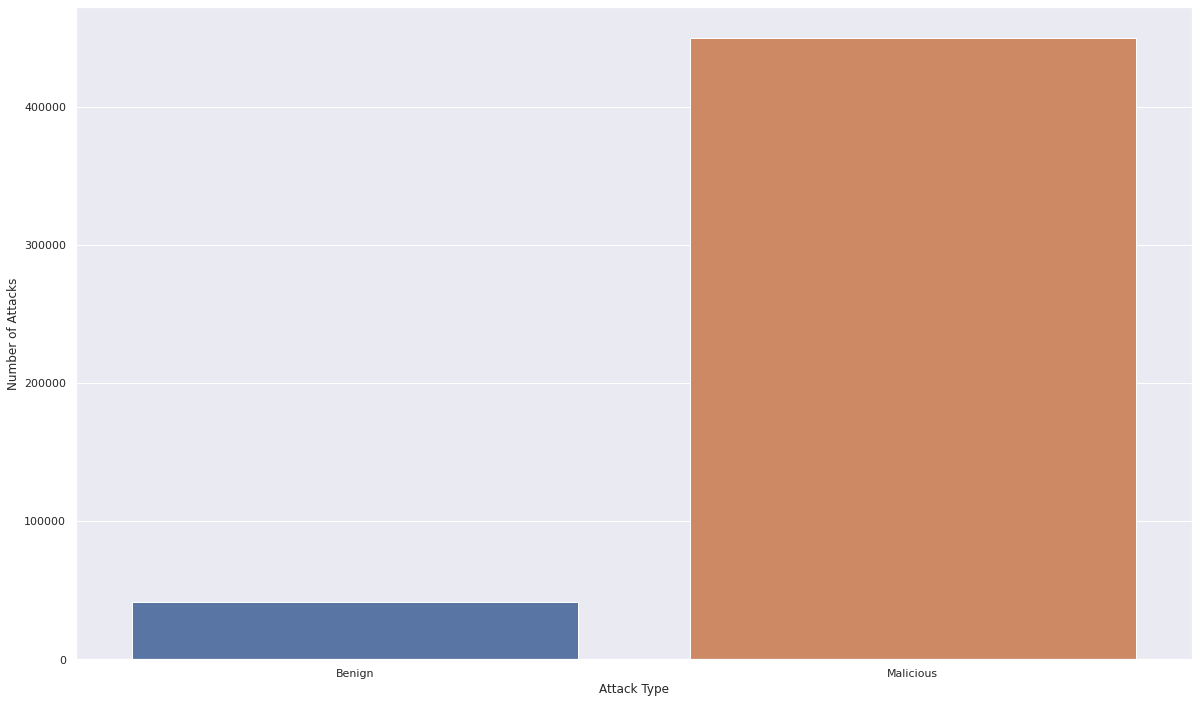

In [11]:
# make a plot number of labels
sns.set(rc={'figure.figsize':(20, 12)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='Label', data=data)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.show()

In [12]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

In [13]:
data.shape

(312111, 80)

In [14]:
data["Label"].value_counts()

Malicious    271072
Benign        41039
Name: Label, dtype: int64

In [15]:
data["Protocol"].unique()

array([ 0.,  6., 17.])

In [16]:
# Forcing them to be strings
data = data.astype({"Protocol": str})

In [17]:
data = pd.get_dummies(data, columns=['Protocol'], drop_first=True)

In [18]:
columns_to_drop = [
    'Dst Port',
    'Timestamp',
    'Fwd PSH Flags',
    'Bwd PSH Flags',
    'Fwd URG Flags',
    'Bwd URG Flags',
    'Flow Byts/s',  # This field had np.inf values during training, as such was removed
    'Flow Pkts/s'  # This field had np.inf values during training, as such was removed
]

In [19]:
data.drop(columns=columns_to_drop, inplace=True)

In [20]:
data.replace(to_replace="Benign", value=0, inplace=True)
data.replace(to_replace="Malicious", value=1, inplace=True)

In [21]:
data["Label"].unique()

array([0, 1])

In [22]:
# making Label column the last column again
data.insert(len(data.columns)-1, 'Label', data.pop('Label'))
data

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_17.0,Protocol_6.0,Label
0,112641719.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,56320859.5,139.300036,56320958.0,56320761.0,0,0,0
1,112641466.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,56320733.0,114.551299,56320814.0,56320652.0,0,0,0
2,112638623.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,56319311.5,301.934596,56319525.0,56319098.0,0,0,0
3,6453966.0,15.0,10.0,1239.0,2273.0,744.0,0.0,82.600000,196.741237,976.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
4,8804066.0,14.0,11.0,1143.0,2209.0,744.0,0.0,81.642857,203.745545,976.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88636,42887.0,2.0,2.0,100.0,264.0,50.0,50.0,50.000000,0.000000,132.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,0,0
88637,1217.0,1.0,1.0,30.0,78.0,30.0,30.0,30.000000,0.000000,78.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1,0,0
88638,1711199.0,8.0,7.0,1144.0,1581.0,677.0,0.0,143.000000,227.969923,1173.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0
88639,543763.0,7.0,4.0,286.0,170.0,103.0,0.0,40.857143,51.141727,131.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,1,0


In [23]:
x=data.drop(columns="Label")
y=data["Label"]

In [24]:
y

0        0
1        0
2        0
3        0
4        0
        ..
88636    0
88637    0
88638    0
88639    0
88640    0
Name: Label, Length: 312111, dtype: int64

In [25]:
print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

sm = SMOTE(random_state=2)
x, y = sm.fit_resample(x, y)

print("After OverSampling, counts of label '1': {}".format(sum(y==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y==0)))

Before OverSampling, counts of label '1': 271072
Before OverSampling, counts of label '0': 41039 

After OverSampling, counts of label '1': 271072
After OverSampling, counts of label '0': 271072


In [26]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    plt.show()
    ax = plt.gca()
    ax.set_aspect('equal')

In [27]:
def fold_cross_validation(splits,model):

    kf = KFold(n_splits=splits, shuffle=True, random_state=42)
    cross_val_accuracy = 0
    for fold, (tr_index , val_index) in enumerate(kf.split(data)):

        print("⁙" * 10)
        print(f"Fold {fold + 1}")

        x_train,x_val = x.values[tr_index] , x.values[val_index]
        y_train,y_val = y.values[tr_index] , y.values[val_index]

        model.fit(x_train, y_train)
        predictions = model.predict(x_val)
        print("accuracy score :",accuracy_score(y_val, predictions))
        cross_val_accuracy += accuracy_score(y_val, predictions)
        print(classification_report(y_val, predictions, digits=5))
        print("ROC AUC score :",roc_auc_score(y_val,predictions))
        print("PR AUC score :",average_precision_score(y_val,predictions))
        print("log loss :",log_loss(y_val,predictions))
        print("brier loss score :",brier_score_loss(y_val, predictions))
        print("geometric mean score :",geometric_mean_score(y_val, predictions, average='weighted'))
        plot_roc("Test", y_val, predictions, linestyle='--')
        print("confusion matrix \n",confusion_matrix(y_val, predictions))

    cross_val_accuracy /= 5

In [28]:
    decisiontree = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=19,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0)

⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 1
accuracy score : 0.9993912500200247
              precision    recall  f1-score   support

           0    0.99839   0.99691   0.99765      8088
           1    0.99954   0.99976   0.99965     54335

    accuracy                        0.99939     62423
   macro avg    0.99897   0.99833   0.99865     62423
weighted avg    0.99939   0.99939   0.99939     62423

ROC AUC score : 0.998334872262297
PR AUC score : 0.9995091031751115
log loss : 0.02102579967227501
brier loss score : 0.0006087499799753296
geometric mean score : 0.9983343133645212


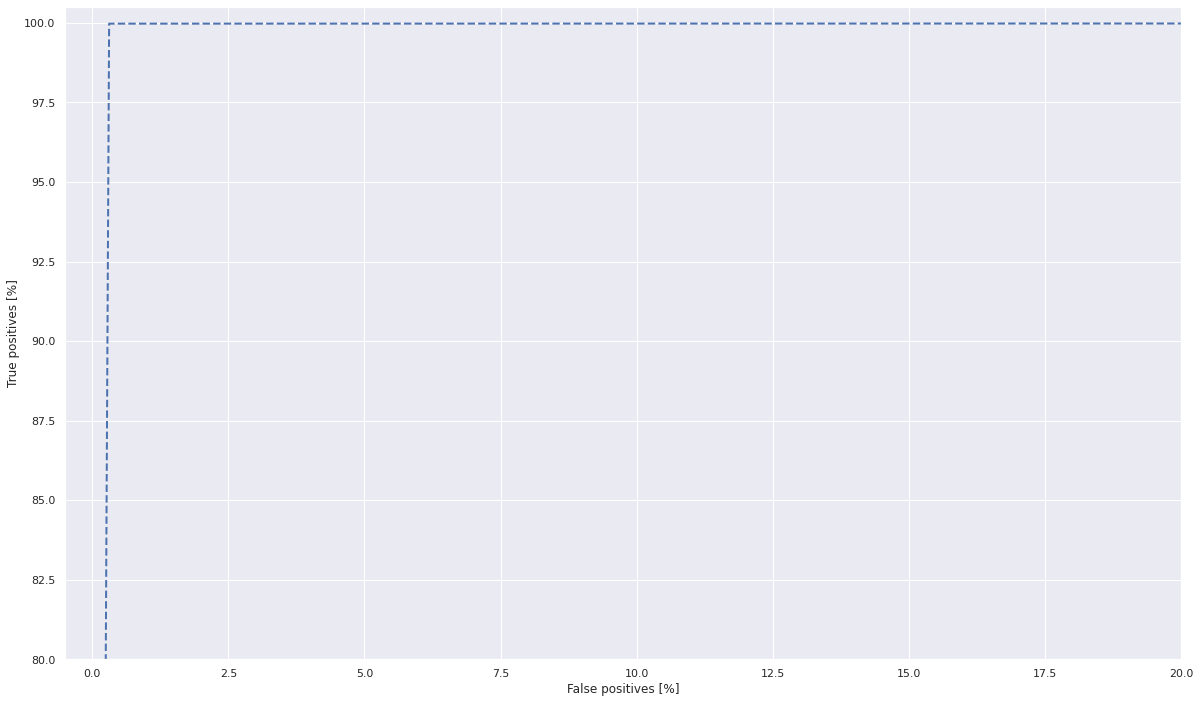

confusion matrix 
 [[ 8063    25]
 [   13 54322]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 2
accuracy score : 0.9993431802890007
              precision    recall  f1-score   support

           0    0.99853   0.99646   0.99750      8202
           1    0.99947   0.99978   0.99962     54220

    accuracy                        0.99934     62422
   macro avg    0.99900   0.99812   0.99856     62422
weighted avg    0.99934   0.99934   0.99934     62422

ROC AUC score : 0.9981214782298422
PR AUC score : 0.9994363473669061
log loss : 0.02268612060678728
brier loss score : 0.0006568197109993271
geometric mean score : 0.9981207305470636


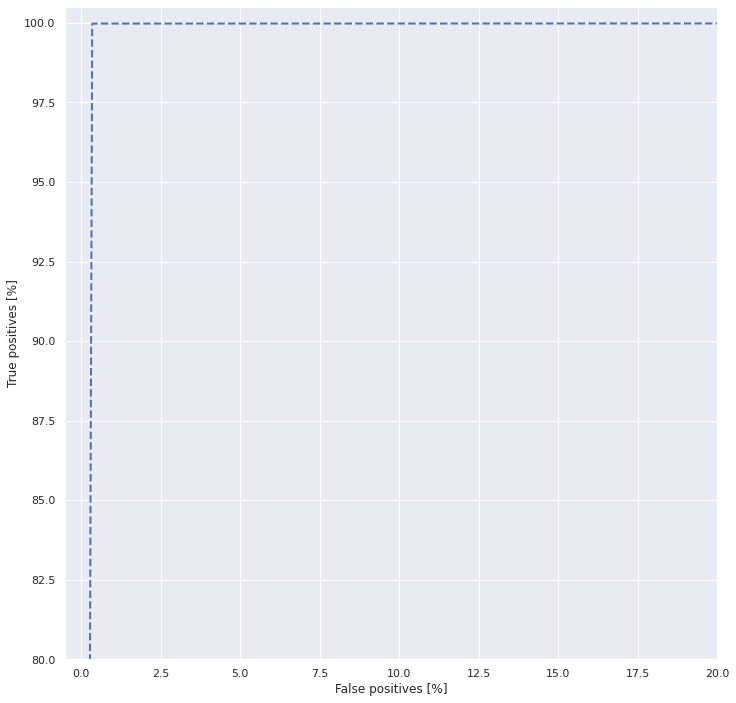

confusion matrix 
 [[ 8173    29]
 [   12 54208]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 3
accuracy score : 0.9993271602960495
              precision    recall  f1-score   support

           0    0.99818   0.99673   0.99746      8261
           1    0.99950   0.99972   0.99961     54161

    accuracy                        0.99933     62422
   macro avg    0.99884   0.99823   0.99853     62422
weighted avg    0.99933   0.99933   0.99933     62422

ROC AUC score : 0.9982273392514168
PR AUC score : 0.9994650826140871
log loss : 0.02323940594208654
brier loss score : 0.0006728397039505303
geometric mean score : 0.9982267333740531


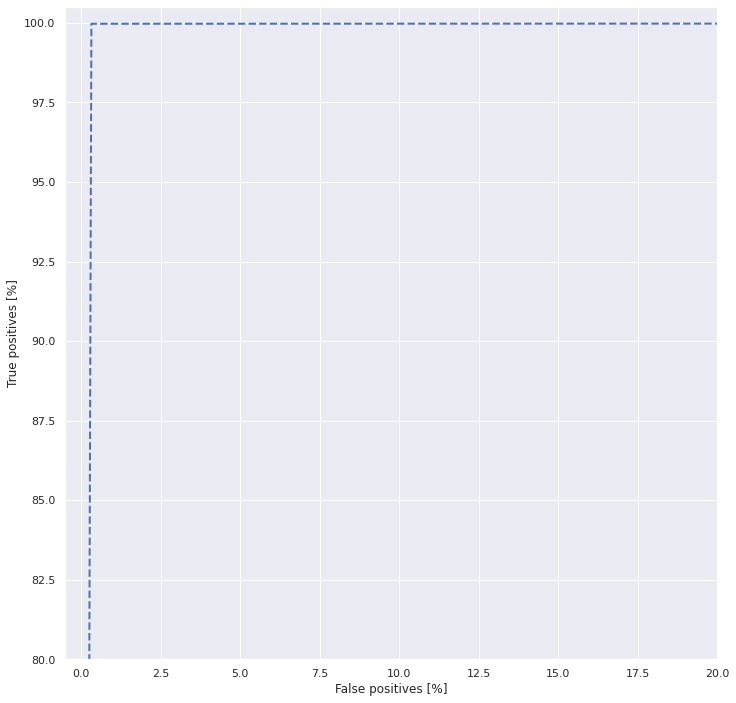

confusion matrix 
 [[ 8234    27]
 [   15 54146]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 4
accuracy score : 0.999134920380635
              precision    recall  f1-score   support

           0    0.99733   0.99612   0.99672      8248
           1    0.99941   0.99959   0.99950     54174

    accuracy                        0.99913     62422
   macro avg    0.99837   0.99786   0.99811     62422
weighted avg    0.99913   0.99913   0.99913     62422

ROC AUC score : 0.9978570863571873
PR AUC score : 0.9993560005671888
log loss : 0.02987920144248831
brier loss score : 0.0008650796193649675
geometric mean score : 0.9978562681736601


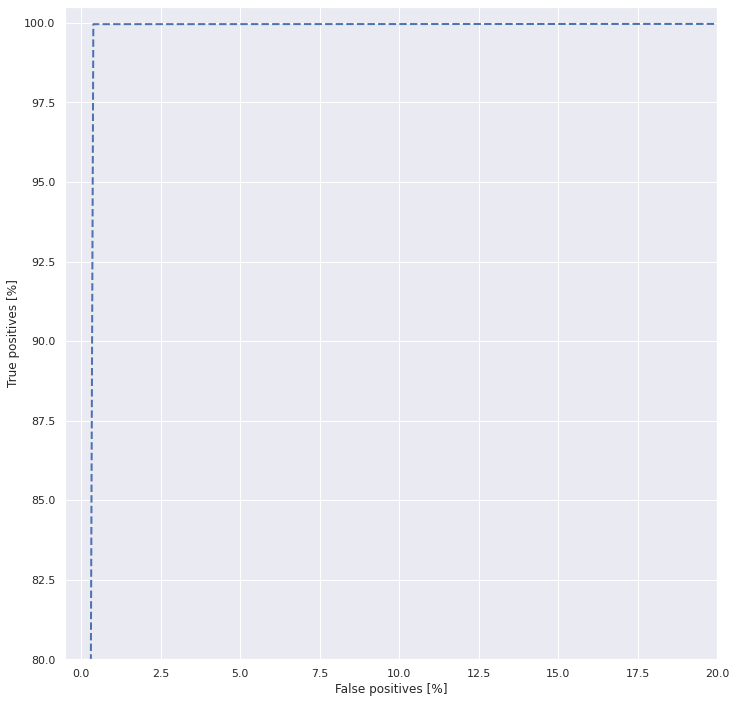

confusion matrix 
 [[ 8216    32]
 [   22 54152]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 5
accuracy score : 0.9992791003171959
              precision    recall  f1-score   support

           0    0.99854   0.99600   0.99727      8240
           1    0.99939   0.99978   0.99958     54182

    accuracy                        0.99928     62422
   macro avg    0.99897   0.99789   0.99843     62422
weighted avg    0.99928   0.99928   0.99928     62422

ROC AUC score : 0.997886834932104
PR AUC score : 0.9993620765980555
log loss : 0.024899415662526663
brier loss score : 0.0007208996828041396
geometric mean score : 0.9978858636777604


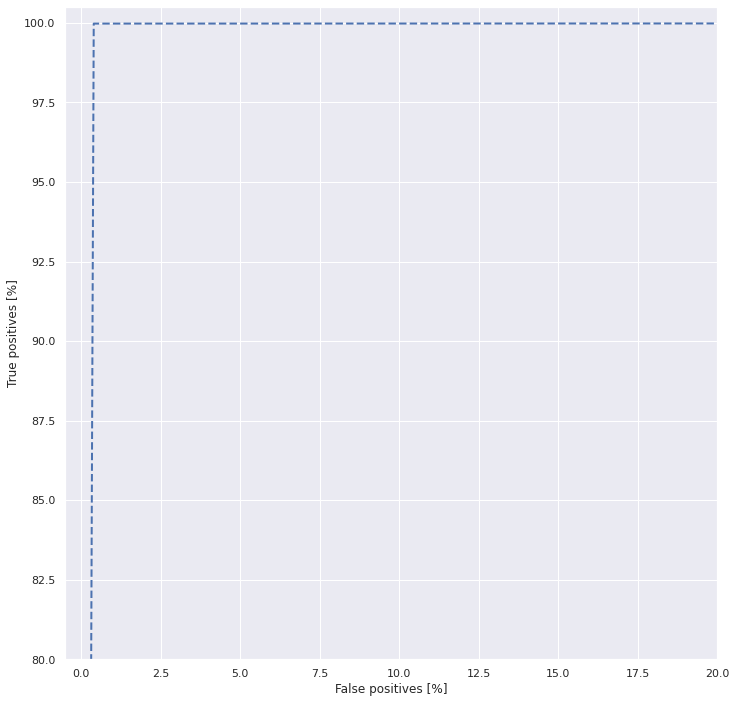

confusion matrix 
 [[ 8207    33]
 [   12 54170]]


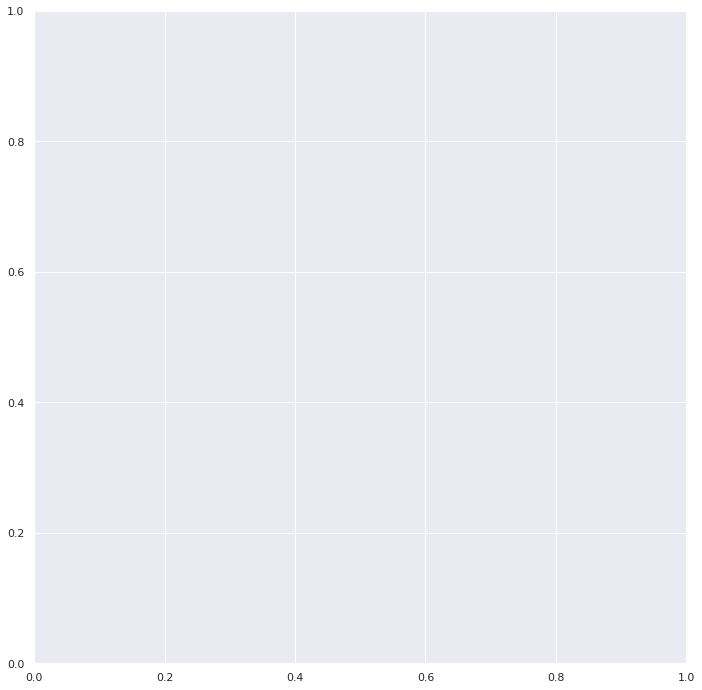

In [29]:
fold_cross_validation(5,decisiontree)

In [30]:
randomforest = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None
)

randomforest = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None
)

⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 1


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



accuracy score : 0.9992470723931884
              precision    recall  f1-score   support

           0    0.99802   0.99617   0.99709      8088
           1    0.99943   0.99971   0.99957     54335

    accuracy                        0.99925     62423
   macro avg    0.99872   0.99794   0.99833     62423
weighted avg    0.99925   0.99925   0.99925     62423

ROC AUC score : 0.9979363458658539
PR AUC score : 0.9993916370600104
log loss : 0.026005595342761492
brier loss score : 0.0007529276068115919
geometric mean score : 0.9979354850871189


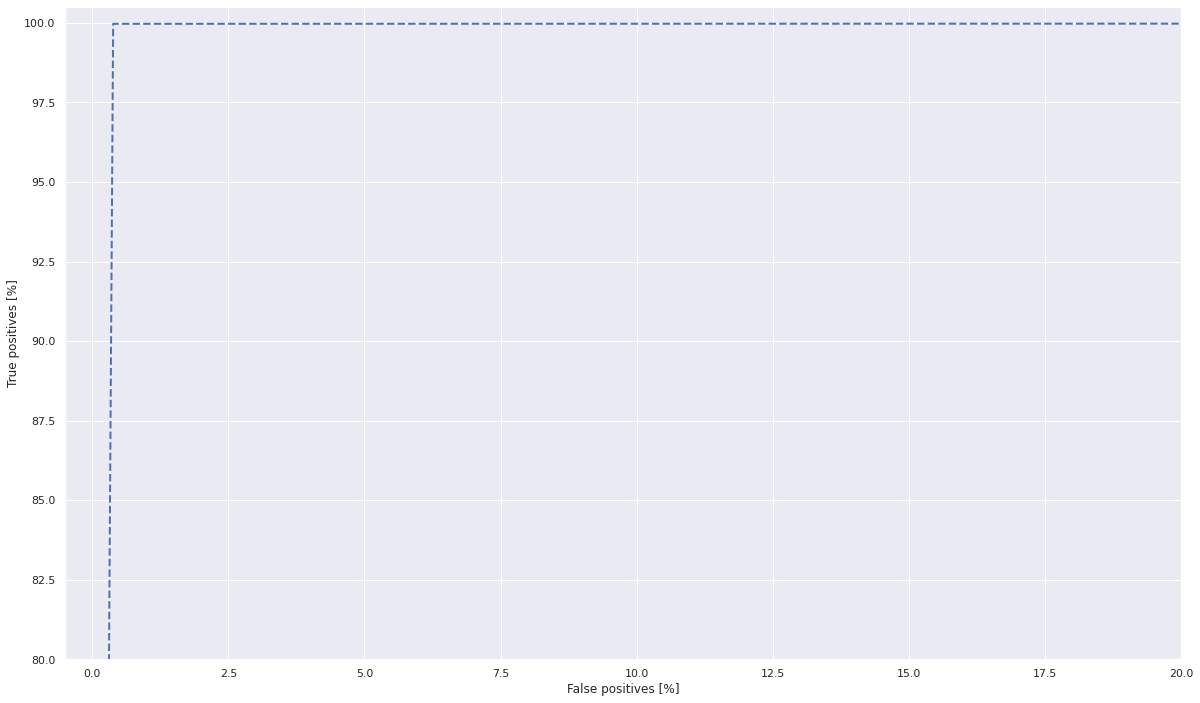

confusion matrix 
 [[ 8057    31]
 [   16 54319]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 2


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



accuracy score : 0.9993592002819519
              precision    recall  f1-score   support

           0    0.99853   0.99659   0.99756      8202
           1    0.99948   0.99978   0.99963     54220

    accuracy                        0.99936     62422
   macro avg    0.99901   0.99818   0.99860     62422
weighted avg    0.99936   0.99936   0.99936     62422

ROC AUC score : 0.9981824389711249
PR AUC score : 0.9994547713677072
log loss : 0.022132796842852444
brier loss score : 0.000640799718048124
geometric mean score : 0.9981817453265516


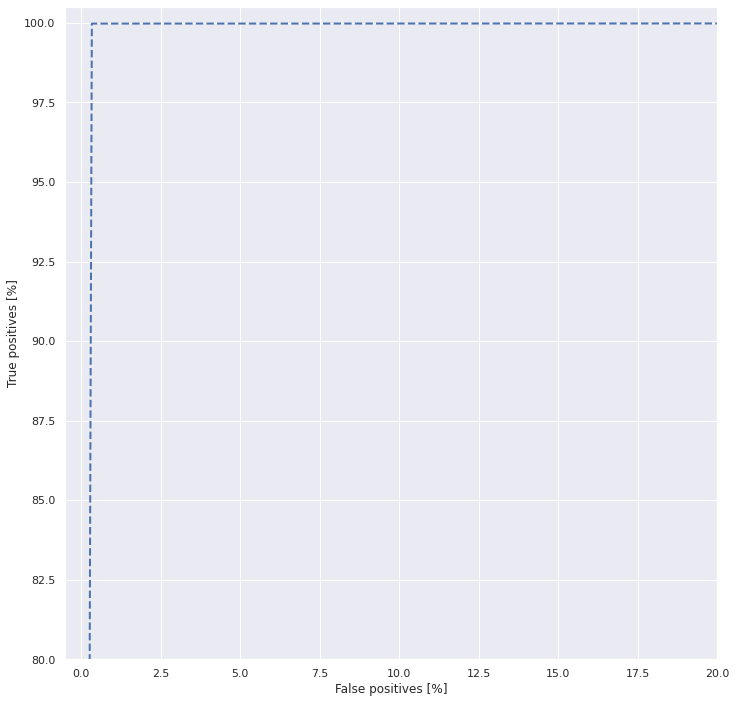

confusion matrix 
 [[ 8174    28]
 [   12 54208]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 3


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



accuracy score : 0.9993431802890007
              precision    recall  f1-score   support

           0    0.99842   0.99661   0.99752      8261
           1    0.99948   0.99976   0.99962     54161

    accuracy                        0.99934     62422
   macro avg    0.99895   0.99819   0.99857     62422
weighted avg    0.99934   0.99934   0.99934     62422

ROC AUC score : 0.9981852773613152
PR AUC score : 0.9994515248287442
log loss : 0.022686107797242082
brier loss score : 0.0006568197109993271
geometric mean score : 0.9981846057727479


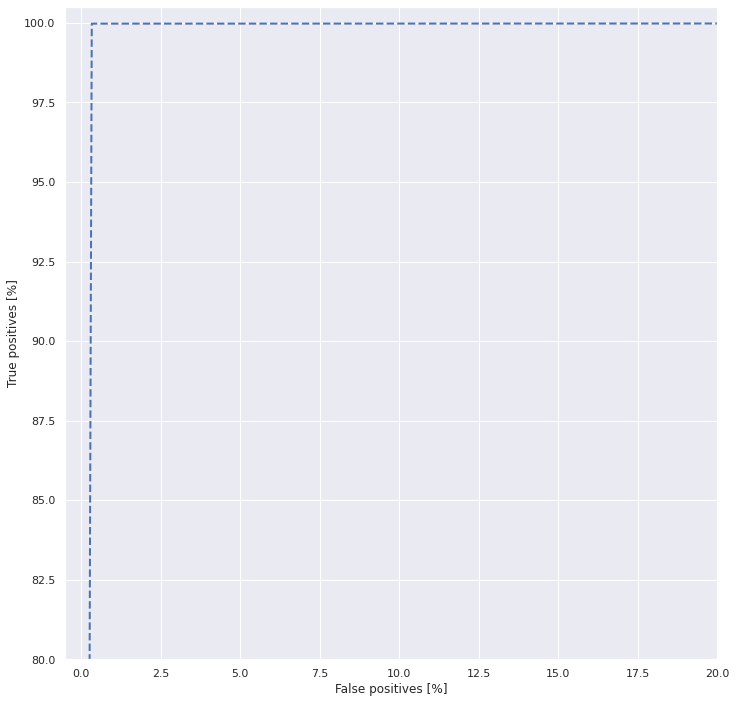

confusion matrix 
 [[ 8233    28]
 [   13 54148]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 4


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



accuracy score : 0.999215020345391
              precision    recall  f1-score   support

           0    0.99830   0.99576   0.99703      8248
           1    0.99935   0.99974   0.99955     54174

    accuracy                        0.99922     62422
   macro avg    0.99883   0.99775   0.99829     62422
weighted avg    0.99921   0.99922   0.99921     62422

ROC AUC score : 0.9977490602451125
PR AUC score : 0.9993202042111559
log loss : 0.02711268509917565
brier loss score : 0.000784979654608952
geometric mean score : 0.9977479833008881


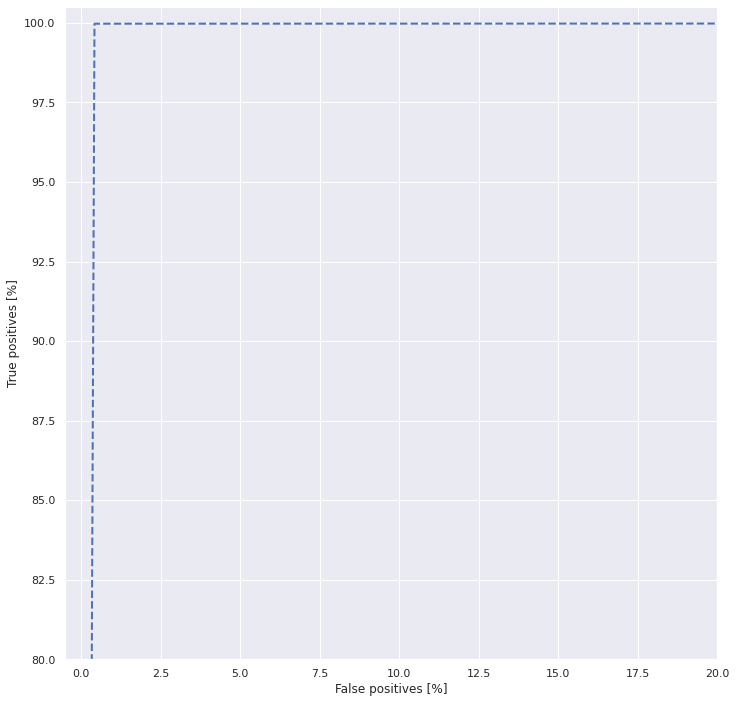

confusion matrix 
 [[ 8213    35]
 [   14 54160]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 5


/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



accuracy score : 0.9991509403735862
              precision    recall  f1-score   support

           0    0.99817   0.99539   0.99678      8240
           1    0.99930   0.99972   0.99951     54182

    accuracy                        0.99915     62422
   macro avg    0.99874   0.99756   0.99815     62422
weighted avg    0.99915   0.99915   0.99915     62422

ROC AUC score : 0.9975557524029941
PR AUC score : 0.9992626069262878
log loss : 0.029325967345369835
brier loss score : 0.0008490596264137644
geometric mean score : 0.9975544769723818


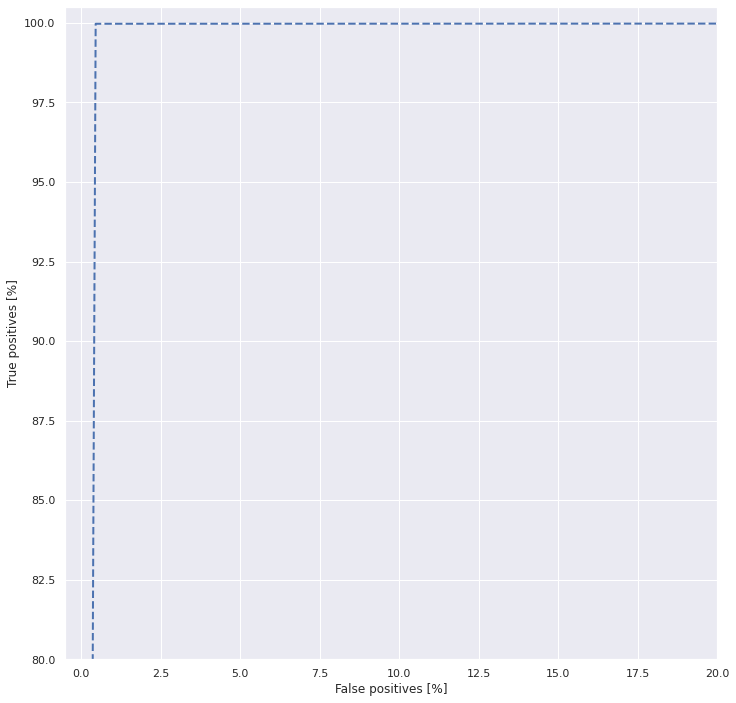

confusion matrix 
 [[ 8202    38]
 [   15 54167]]


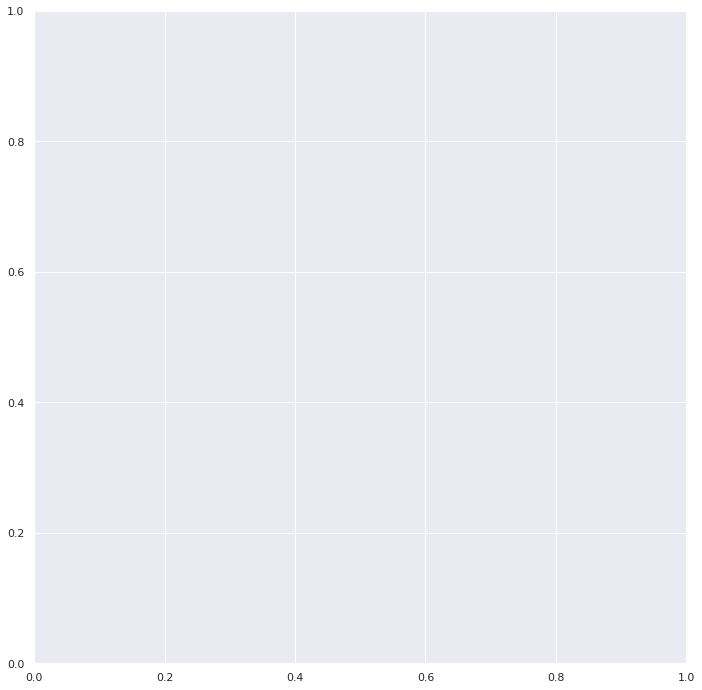

In [31]:
fold_cross_validation(5,randomforest)

In [32]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)





⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 1
accuracy score : 0.999535427646861
              precision    recall  f1-score   support

           0    0.99876   0.99765   0.99821      8088
           1    0.99965   0.99982   0.99973     54335

    accuracy                        0.99954     62423
   macro avg    0.99921   0.99873   0.99897     62423
weighted avg    0.99954   0.99954   0.99954     62423

ROC AUC score : 0.9987333986587403
PR AUC score : 0.9996265936614427
log loss : 0.016046004001788534
brier loss score : 0.0004645723531390673
geometric mean score : 0.9987330766255519


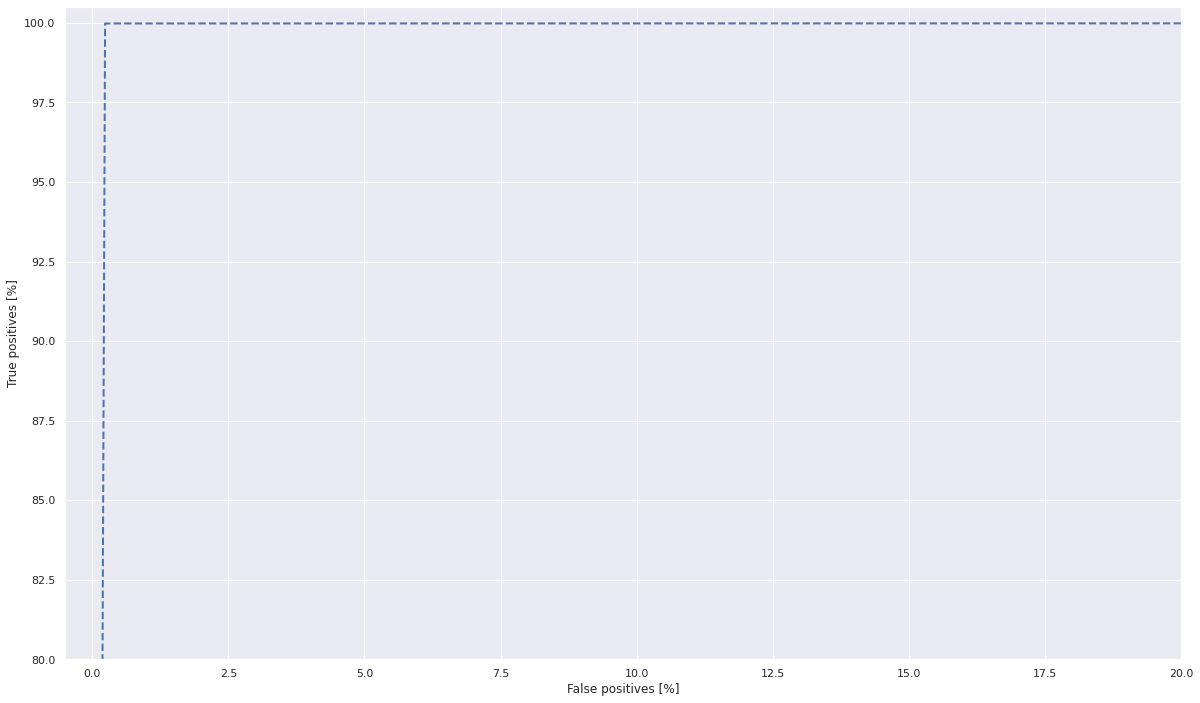

confusion matrix 
 [[ 8069    19]
 [   10 54325]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 2
accuracy score : 0.9995995001762199
              precision    recall  f1-score   support

           0    0.99927   0.99768   0.99847      8202
           1    0.99965   0.99989   0.99977     54220

    accuracy                        0.99960     62422
   macro avg    0.99946   0.99879   0.99912     62422
weighted avg    0.99960   0.99960   0.99960     62422

ROC AUC score : 0.9987864157791494
PR AUC score : 0.9996351582547152
log loss : 0.013833017241100943
brier loss score : 0.00040049982378007753
geometric mean score : 0.9987860848243347


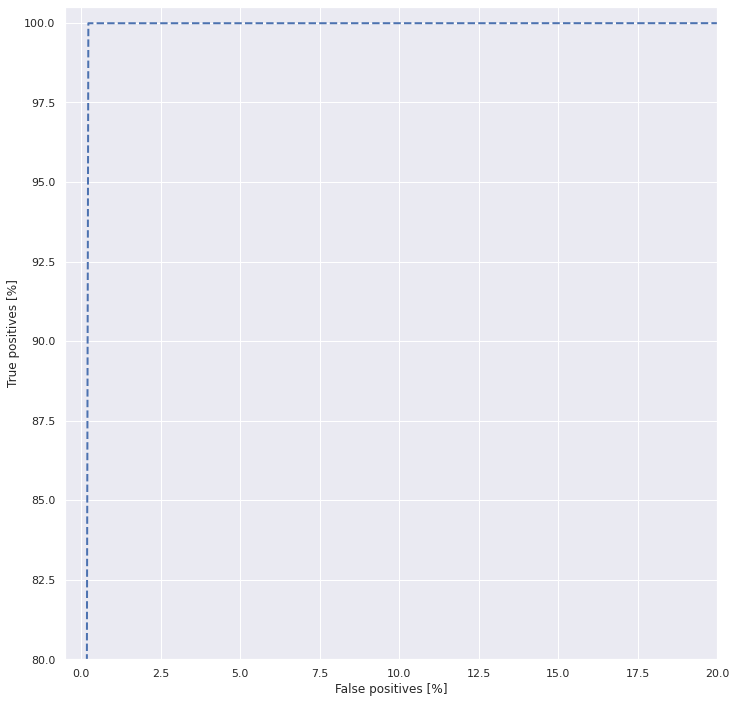

confusion matrix 
 [[ 8183    19]
 [    6 54214]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 3
accuracy score : 0.9995834801832687
              precision    recall  f1-score   support

           0    0.99891   0.99794   0.99843      8261
           1    0.99969   0.99983   0.99976     54161

    accuracy                        0.99958     62422
   macro avg    0.99930   0.99889   0.99909     62422
weighted avg    0.99958   0.99958   0.99958     62422

ROC AUC score : 0.9988879832627493
PR AUC score : 0.9996642282213929
log loss : 0.0143863025764002
brier loss score : 0.00041651981673128066
geometric mean score : 0.9988877411354872


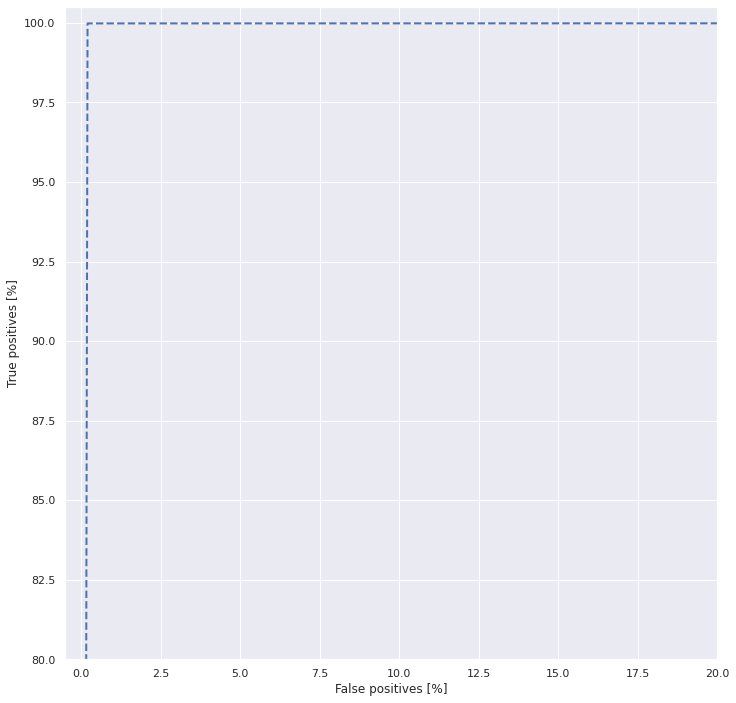

confusion matrix 
 [[ 8244    17]
 [    9 54152]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 4
accuracy score : 0.9995354202044151
              precision    recall  f1-score   support

           0    0.99951   0.99697   0.99824      8248
           1    0.99954   0.99993   0.99973     54174

    accuracy                        0.99954     62422
   macro avg    0.99953   0.99845   0.99899     62422
weighted avg    0.99954   0.99954   0.99954     62422

ROC AUC score : 0.9984475630075409
PR AUC score : 0.9995289807070133
log loss : 0.016046337915930714
brier loss score : 0.0004645797955848899
geometric mean score : 0.9984469703706934


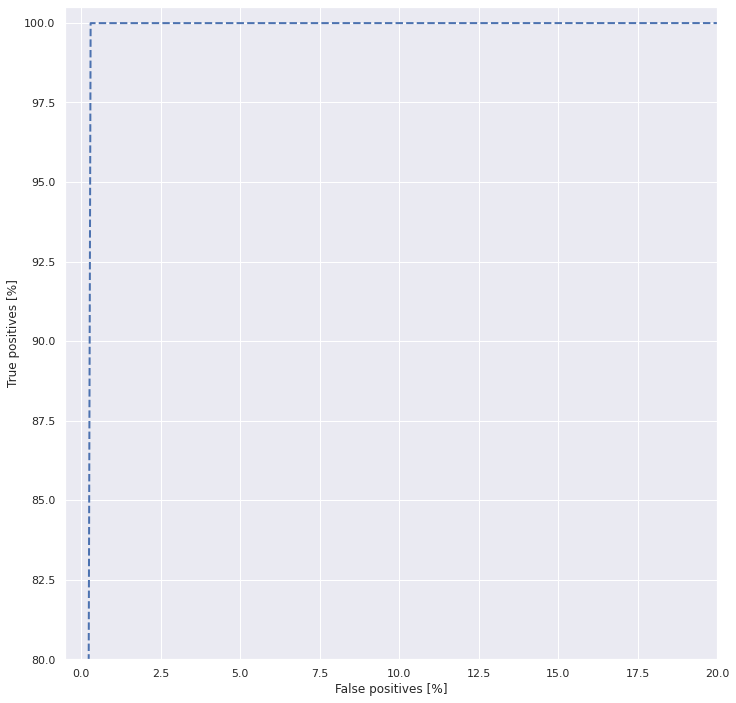

confusion matrix 
 [[ 8223    25]
 [    4 54170]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 5
accuracy score : 0.9994713402326103
              precision    recall  f1-score   support

           0    0.99951   0.99648   0.99799      8240
           1    0.99947   0.99993   0.99970     54182

    accuracy                        0.99947     62422
   macro avg    0.99949   0.99820   0.99885     62422
weighted avg    0.99947   0.99947   0.99947     62422

ROC AUC score : 0.9982033786343261
PR AUC score : 0.9994553079552944
log loss : 0.018259632971670086
brier loss score : 0.0005286597673897024
geometric mean score : 0.9982025733238563


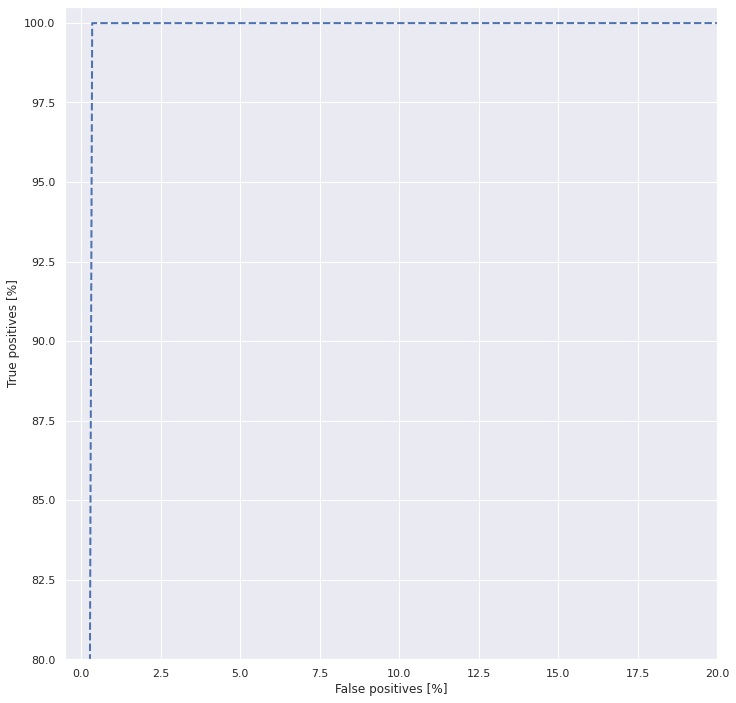

confusion matrix 
 [[ 8211    29]
 [    4 54178]]


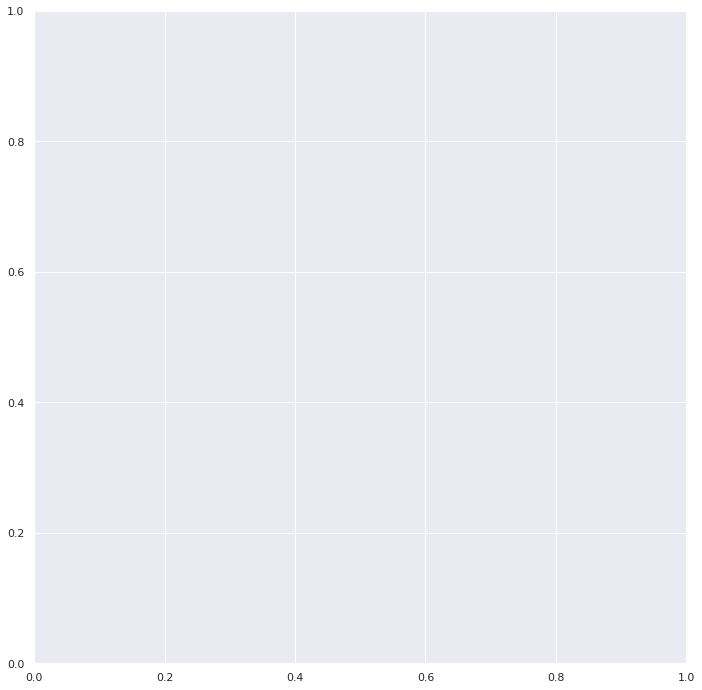

In [33]:
fold_cross_validation(5,xgboost)

In [34]:
adaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                              learning_rate=0.1,
                              n_estimators=100)

⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 1
accuracy score : 0.9983659868958557
              precision    recall  f1-score   support

           0    0.99689   0.99048   0.99367      8088
           1    0.99858   0.99954   0.99906     54335

    accuracy                        0.99837     62423
   macro avg    0.99774   0.99501   0.99637     62423
weighted avg    0.99836   0.99837   0.99836     62423

ROC AUC score : 0.9950098072304311
PR AUC score : 0.9985252567284264
log loss : 0.0564377995495743
brier loss score : 0.0016340131041443057
geometric mean score : 0.9950041469977868


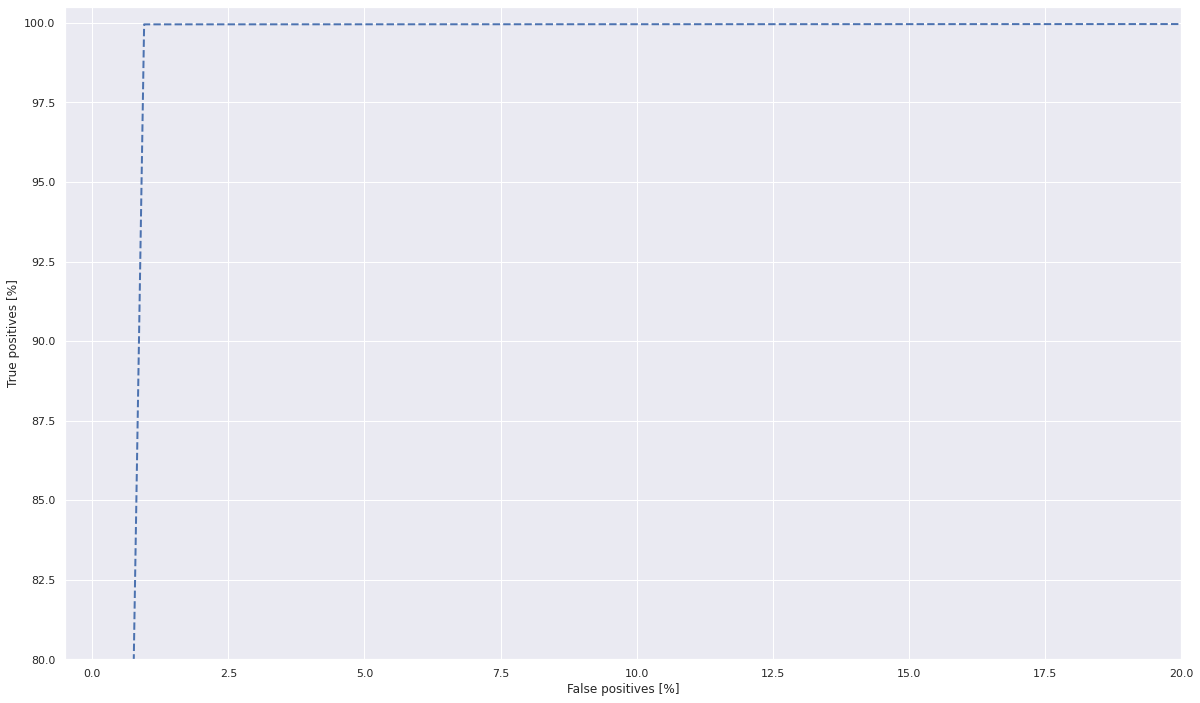

confusion matrix 
 [[ 8011    77]
 [   25 54310]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 2
accuracy score : 0.9974848611066611
              precision    recall  f1-score   support

           0    0.99459   0.98622   0.99039      8202
           1    0.99792   0.99919   0.99855     54220

    accuracy                        0.99748     62422
   macro avg    0.99625   0.99271   0.99447     62422
weighted avg    0.99748   0.99748   0.99748     62422

ROC AUC score : 0.9927056819008706
PR AUC score : 0.9978136071738997
log loss : 0.08687126731778301
brier loss score : 0.002515138893338887
geometric mean score : 0.9926941776420326


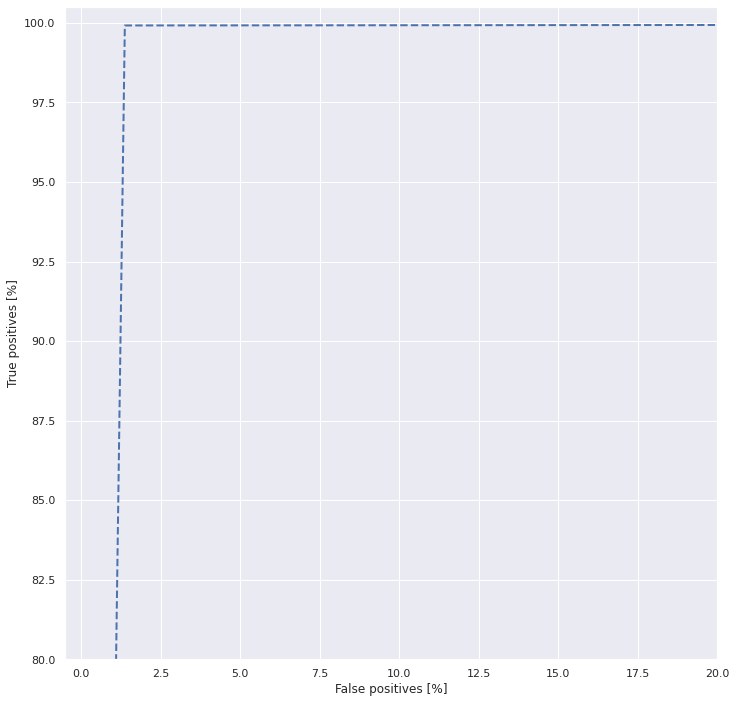

confusion matrix 
 [[ 8089   113]
 [   44 54176]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 3
accuracy score : 0.9979174009163436
              precision    recall  f1-score   support

           0    0.99297   0.99128   0.99213      8261
           1    0.99867   0.99893   0.99880     54161

    accuracy                        0.99792     62422
   macro avg    0.99582   0.99511   0.99546     62422
weighted avg    0.99792   0.99792   0.99792     62422

ROC AUC score : 0.9951067334402237
PR AUC score : 0.9985306752554644
log loss : 0.07193134635790947
brier loss score : 0.002082599083656403
geometric mean score : 0.995102764083394


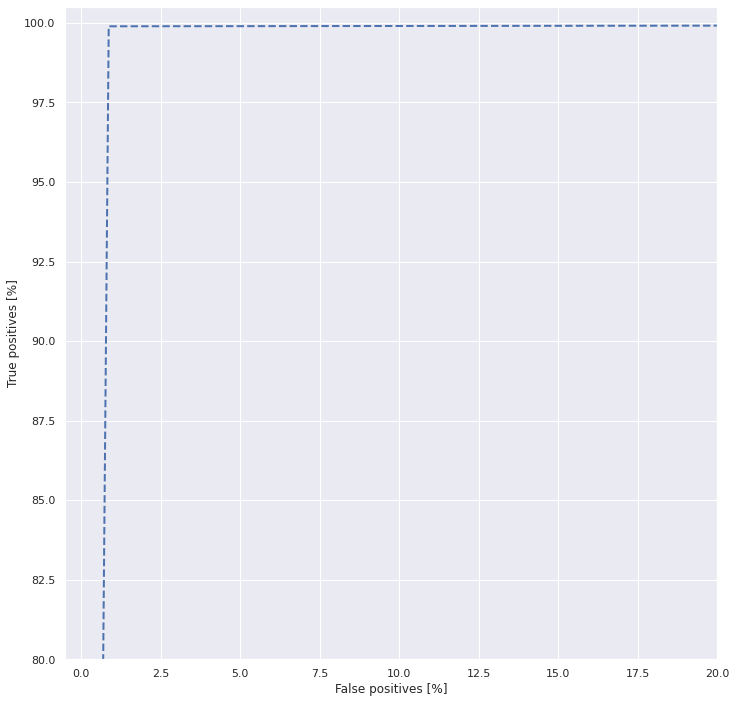

confusion matrix 
 [[ 8189    72]
 [   58 54103]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 4
accuracy score : 0.9980135208740508
              precision    recall  f1-score   support

           0    0.99392   0.99103   0.99247      8248
           1    0.99863   0.99908   0.99886     54174

    accuracy                        0.99801     62422
   macro avg    0.99628   0.99505   0.99566     62422
weighted avg    0.99801   0.99801   0.99801     62422

ROC AUC score : 0.9950525880307292
PR AUC score : 0.9985139438078331
log loss : 0.06861150625066197
brier loss score : 0.0019864791259491844
geometric mean score : 0.9950481826642111


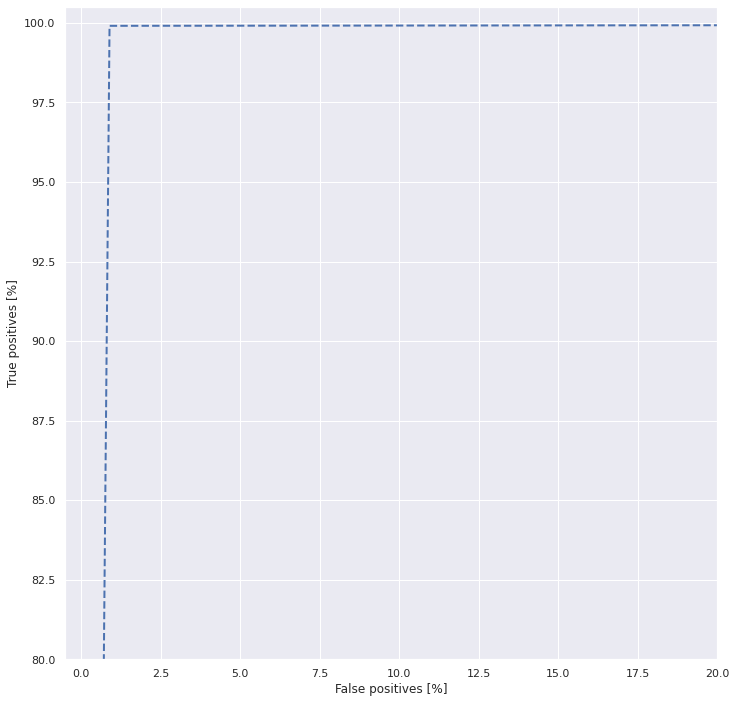

confusion matrix 
 [[ 8174    74]
 [   50 54124]]
⁙⁙⁙⁙⁙⁙⁙⁙⁙⁙
Fold 5
accuracy score : 0.9983179007401237
              precision    recall  f1-score   support

           0    0.99561   0.99163   0.99362      8240
           1    0.99873   0.99934   0.99903     54182

    accuracy                        0.99832     62422
   macro avg    0.99717   0.99548   0.99632     62422
weighted avg    0.99832   0.99832   0.99832     62422

ROC AUC score : 0.9954808931458268
PR AUC score : 0.9986404275647958
log loss : 0.05809853406953264
brier loss score : 0.0016820992598763256
geometric mean score : 0.9954768505627456


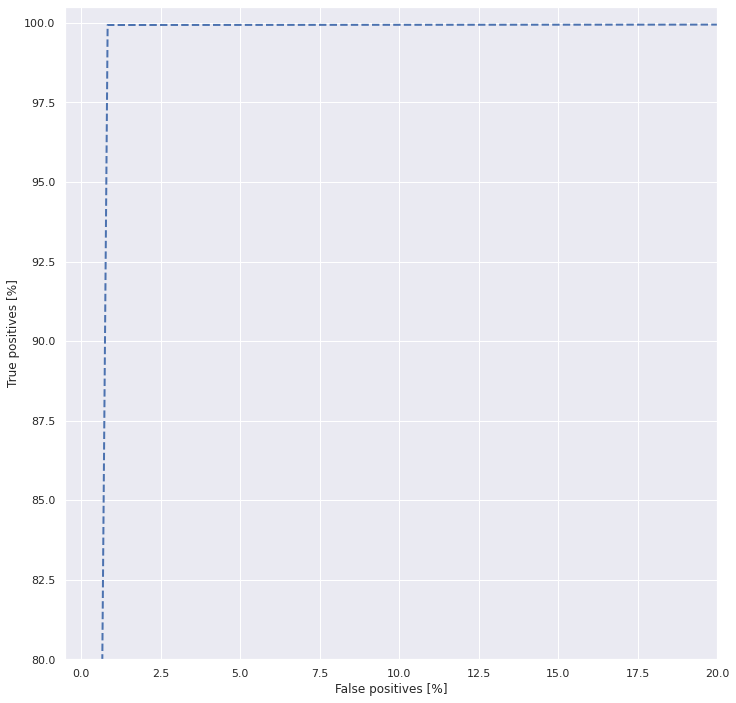

confusion matrix 
 [[ 8171    69]
 [   36 54146]]


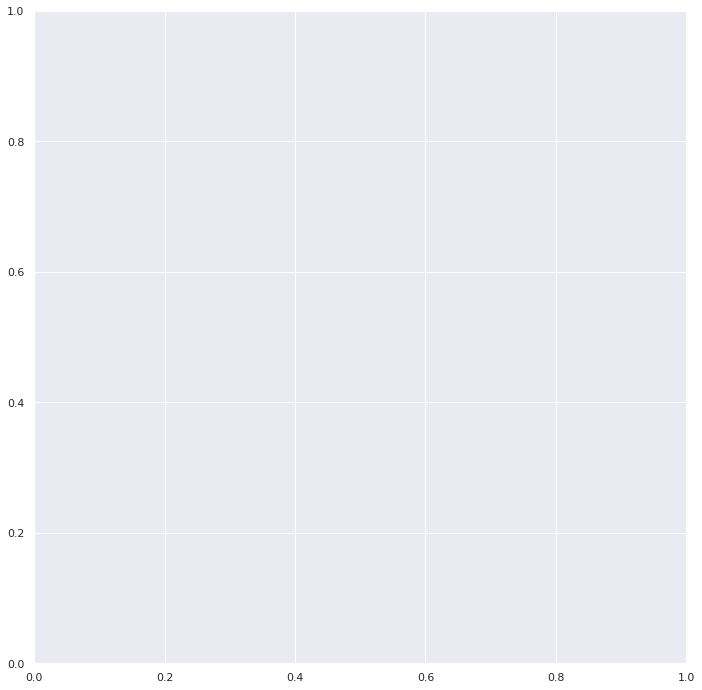

In [35]:
fold_cross_validation(5,adaBoost)

In [36]:
import pickle
xgb_file_name = "xgb_binary.pkl"
rf_file_name = "randomforest_binary.pkl"
decisiontree_file="DecisionTree_binary.pkl"
adaboost_file="adaboost_binary.pkl"
# save
pickle.dump(xgboost, open(xgb_file_name, "wb"))
pickle.dump(randomforest, open(rf_file_name, "wb"))
pickle.dump(decisiontree, open(decisiontree_file, "wb"))
pickle.dump(adaBoost, open(adaboost_file, "wb"))